## LDA Modeling, Tri-Gram

In [1]:
#set up sys
import os, sys
sys.path.append('../PMC_func')


#python basics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging
from collections import Counter

#spacy stuff
import spacy
from spacy.language import Language
from spacy.tokens import Doc
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA, DEP, LEMMA, LOWER, IS_PUNCT, IS_DIGIT, IS_SPACE, IS_STOP
import en_core_web_sm

#gensim stuff
from gensim.models import CoherenceModel, LdaMulticore,LdaModel
from gensim.models.callbacks import ConvergenceMetric
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # don't skip this

#custom dependencies
import PMC_module

#other
import pickle
import warnings
warnings.filterwarnings('ignore')

### Import Data
- Pickled Gensim Objects
- Composite Data Frame

In [2]:
nogram_filename = "../pickled_data/nogram_corpus.pkl"
bigram_filename = "../pickled_data/bigram_corpus.pkl"
trigram_filename = "../pickled_data/trigram_corpus.pkl"
df_lemmatized_texts = "../pickled_data/df_lemmatized_texts.pkl"

with open(nogram_filename, "rb") as f:
    nogram_list_lemmatized_texts, nogram_corpus, nogram_id2word = pickle.load(f)

with open(bigram_filename, "rb") as g:
    bigram_list_lemmatized_texts, bi_corpus, bi_id2word = pickle.load(g)
    
with open(trigram_filename, "rb") as h:
    trigram_list_lemmatized_texts, tri_corpus, tri_id2word = pickle.load(h)
    
with open(df_lemmatized_texts, "rb") as m:
    df_lemmatized_texts = pickle.load(m)

In [3]:
# store raw texts as a list for later
df_list = df_lemmatized_texts.text.tolist()

### Gensim LDA modeling - Hyper Parameter Tunning

#### Coherence Score

In [4]:
logging.basicConfig(filename='model_callbacks.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.NOTSET)

convergence_logger = ConvergenceMetric(logger='shell')

In [5]:
num_topics_list = list(range(5,20,5))
model_lists = []
coherence_list = []

chunksize = 1000
passes = 4
iterations = 200
eval_every = 1
callbacks = [convergence_logger]

for num_topics in num_topics_list:
    lda_model = LdaModel(id2word=tri_id2word, 
                         num_topics=num_topics,
                         corpus=tri_corpus,
                         chunksize=chunksize,
                         alpha='auto',
                         eta='auto',
                         iterations=iterations,
                         passes=passes,
                         eval_every=eval_every,
                         callbacks= callbacks)
                             
    coherence_model_lda = CoherenceModel(model=lda_model, texts=trigram_list_lemmatized_texts, dictionary=tri_id2word, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    model_lists.append(lda_model)
    coherence_list.append(coherence_score)
    print("LDA model/coherence complete for num_topics = ",num_topics, "; score = ", coherence_score)

LDA model/coherence complete for num_topics =  5 ; score =  0.5343040538606378
LDA model/coherence complete for num_topics =  10 ; score =  0.45368193113408595
LDA model/coherence complete for num_topics =  15 ; score =  0.405170267870746


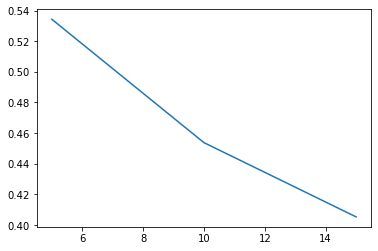

In [6]:
plt.plot(num_topics_list,coherence_list)

#### Topic Component Distribution - 5 topics

In [7]:
opt_topic_index = 0
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

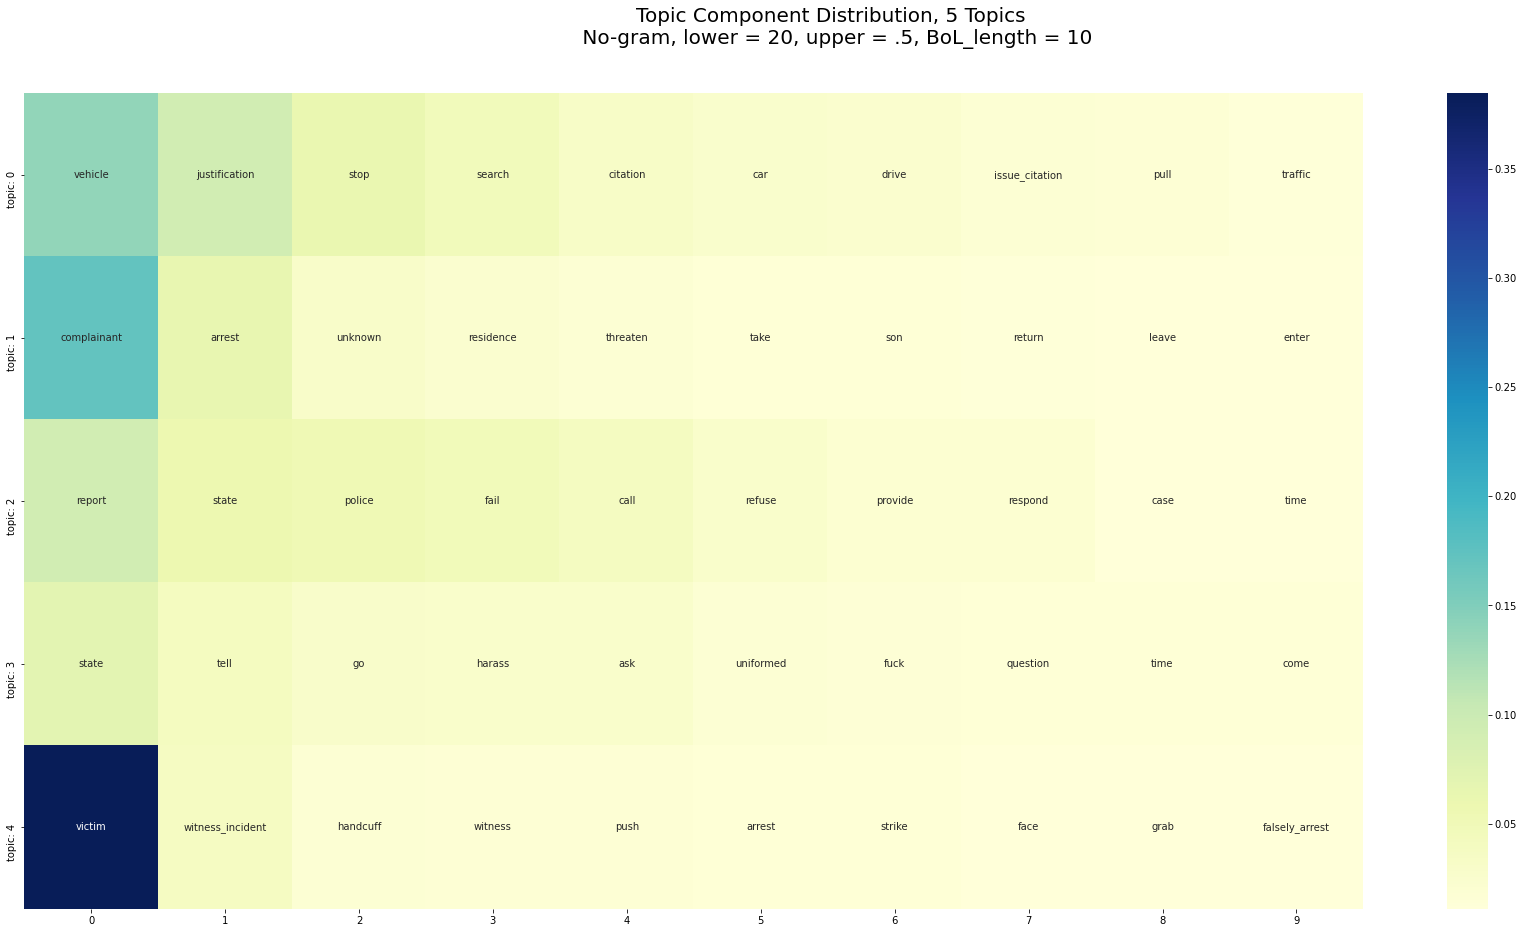

In [8]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 5 Topics \n No-gram, lower = 20, upper = .5, BoL_length = 10", size = 20, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_trigram_5topics1.png')

#### pyLDAvis Principal Component Visualization

In [9]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_trigram_5topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], tri_corpus, tri_id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Use

#### Most Represetative Documents


In [10]:
dom_topic_df_5 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],tri_corpus, trigram_list_lemmatized_texts,df_list)
top_representatives_5 = PMC_module.return_top_representatives(dom_topic_df_5, num_reps = 10)

In [11]:
top_representatives_5[top_representatives_5['Dominant_Topic'] == 0].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
0,10304,0.0,0.7460,"[vehicle, justification, stop, search, citatio...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
1,31262,0.0,0.7064,"[vehicle, justification, stop, search, citatio...","[reporting, party, allege, accuse, stop, searc...",The reporting party alleged that the accused\n...
2,31261,0.0,0.7064,"[vehicle, justification, stop, search, citatio...","[reporting, party, allege, accuse, stop, searc...",The reporting party alleged that the accused\n...
3,934,0.0,0.6937,"[vehicle, justification, stop, search, citatio...","[reporting, party, allege, accuse, officer, cu...",The reporting party alleged that the accused\n...
4,933,0.0,0.6937,"[vehicle, justification, stop, search, citatio...","[reporting, party, allege, accuse, officer, cu...",The reporting party alleged that the accused\n...
5,28360,0.0,0.6907,"[vehicle, justification, stop, search, citatio...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
6,28359,0.0,0.6907,"[vehicle, justification, stop, search, citatio...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
7,25620,0.0,0.6891,"[vehicle, justification, stop, search, citatio...","[plaintiff, allege, accuse, officer, search, v...",The plaintiffs alleged that the accused\noffic...
8,25621,0.0,0.6891,"[vehicle, justification, stop, search, citatio...","[plaintiff, allege, accuse, officer, search, v...",The plaintiffs alleged that the accused\noffic...
9,14774,0.0,0.6891,"[vehicle, justification, stop, search, citatio...","[reporting, party, victim, allege, stop, detai...",The Reporting Party Victim alleged he was\nsto...


In [12]:
topic_of_interest = 0
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_5[top_representatives_5['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 0
---------
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS.
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
------
The reporting party alleged that the accused
stopped and searched him without
justification. The accused also issued him
three false citations
The reporting party alleged that the accused
stopped and searched him without
justifi

#### Topic Component Distribution - 10 topics

In [13]:
opt_topic_index = 1
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

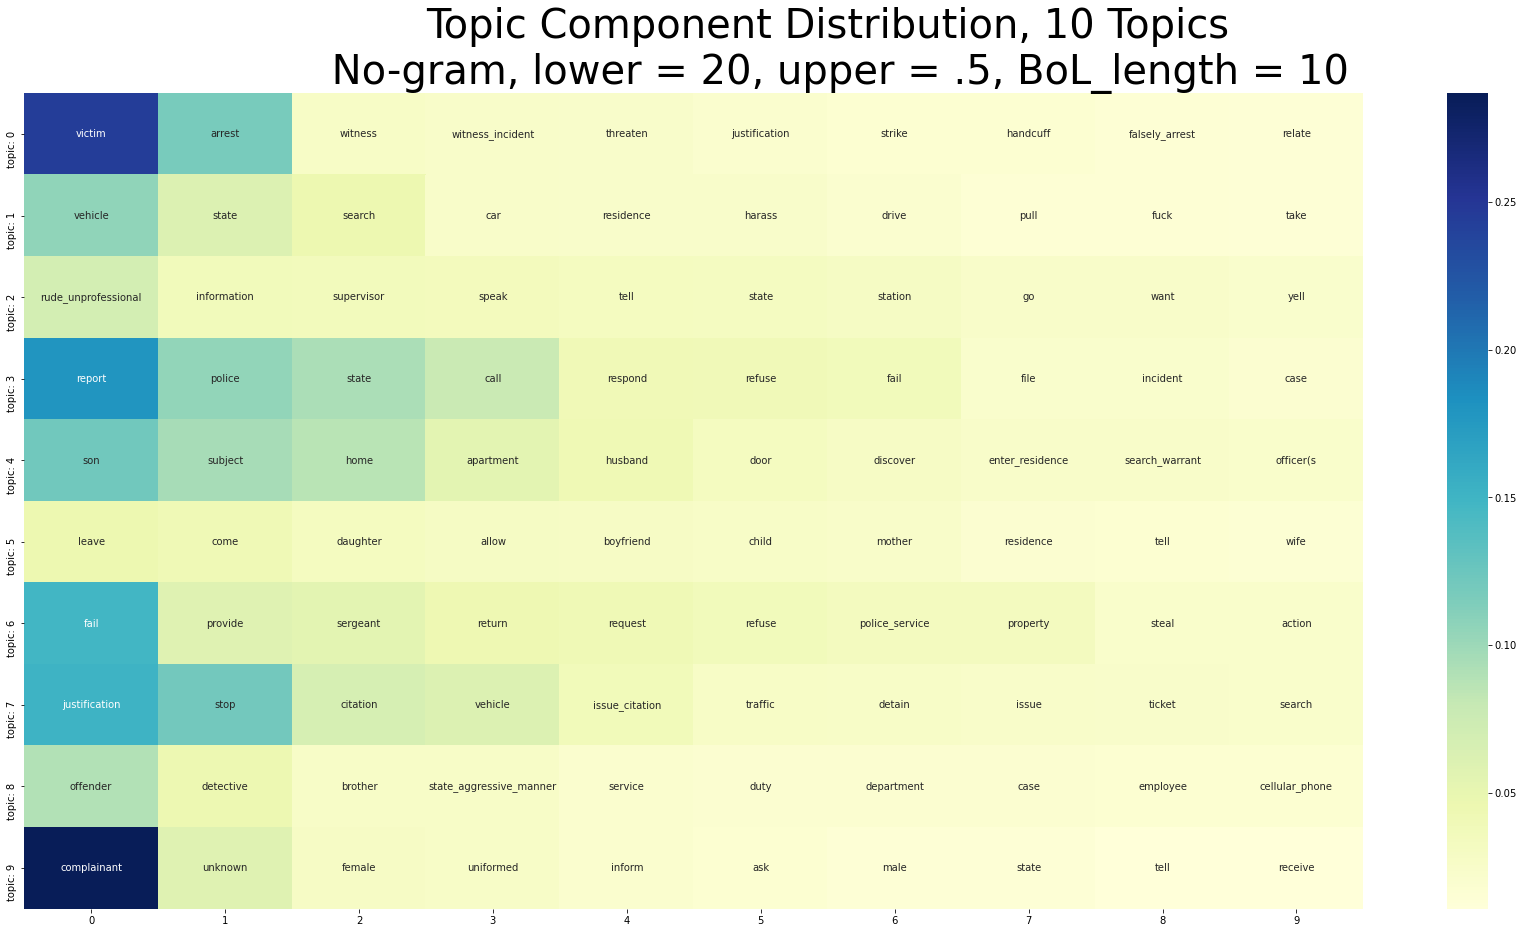

In [14]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 10 Topics \n No-gram, lower = 20, upper = .5, BoL_length = 10", size = 40, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_trigram_10topics1.png')

#### pyLDAvis Principal Component Visualization

In [15]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_trigram_10topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], tri_corpus, tri_id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


#### Most Represetative Documents


In [16]:
dom_topic_df_10 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],tri_corpus, trigram_list_lemmatized_texts,df_list)
top_representatives_10 = PMC_module.return_top_representatives(dom_topic_df_10, num_reps = 10)

In [17]:
top_representatives_10[top_representatives_10['Dominant_Topic'] == 7].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
70,31262,7.0,0.5776,"[justification, stop, citation, vehicle, issue...","[reporting, party, allege, accuse, stop, searc...",The reporting party alleged that the accused\n...
71,31261,7.0,0.5776,"[justification, stop, citation, vehicle, issue...","[reporting, party, allege, accuse, stop, searc...",The reporting party alleged that the accused\n...
72,12567,7.0,0.5201,"[justification, stop, citation, vehicle, issue...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
73,20746,7.0,0.5094,"[justification, stop, citation, vehicle, issue...","[reporting, party, allege, accuse, issue, vict...",The reporting party alleged that the accused\n...
74,7602,7.0,0.5059,"[justification, stop, citation, vehicle, issue...","[reporting, party, allege, traffic_stop, accus...",THE REPORTING PARTY ALLEGES THAT\nDURING A TRA...
75,12781,7.0,0.4960,"[justification, stop, citation, vehicle, issue...","[reporting, party, allege, accuse, officer, st...",The reporting party alleged that the accused\n...
76,12782,7.0,0.4960,"[justification, stop, citation, vehicle, issue...","[reporting, party, allege, accuse, officer, st...",The reporting party alleged that the accused\n...
77,28188,7.0,0.4914,"[justification, stop, citation, vehicle, issue...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
78,11493,7.0,0.4905,"[justification, stop, citation, vehicle, issue...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
79,7335,7.0,0.4890,"[justification, stop, citation, vehicle, issue...","[reporting, party, allege, today_date, accuse,...",THE REPORTING PARTY ALLEGES THAT\nON TODAY'S D...


In [18]:
topic_of_interest = 7
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_10[top_representatives_10['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 7
---------
The reporting party alleged that the accused
stopped and searched him without
justification. The accused also issued him
three false citations
The reporting party alleged that the accused
stopped and searched him without
justification. The accused also issued him
three false citations
The reporting party alleged that the accused
stopped and searched him without
justification. The accused also issued him
three false citations.
------
The reporting party alleged that the accused
stopped and searched him without
justification. The accused also issued him
three false citations
The reporting party alleged that the accused
stopped and searched him without
justification. The accused also issued him
three false citations.
 The reporting party alleged that the accused
stopped and searched him without
justification. The accused also issued him
three false citations
------
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED HER
AND ISSUED HER A CITATION WITHOUT
JUSTIFI

#### Topic Component Distribution - 15 topics

In [19]:
opt_topic_index = 2
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

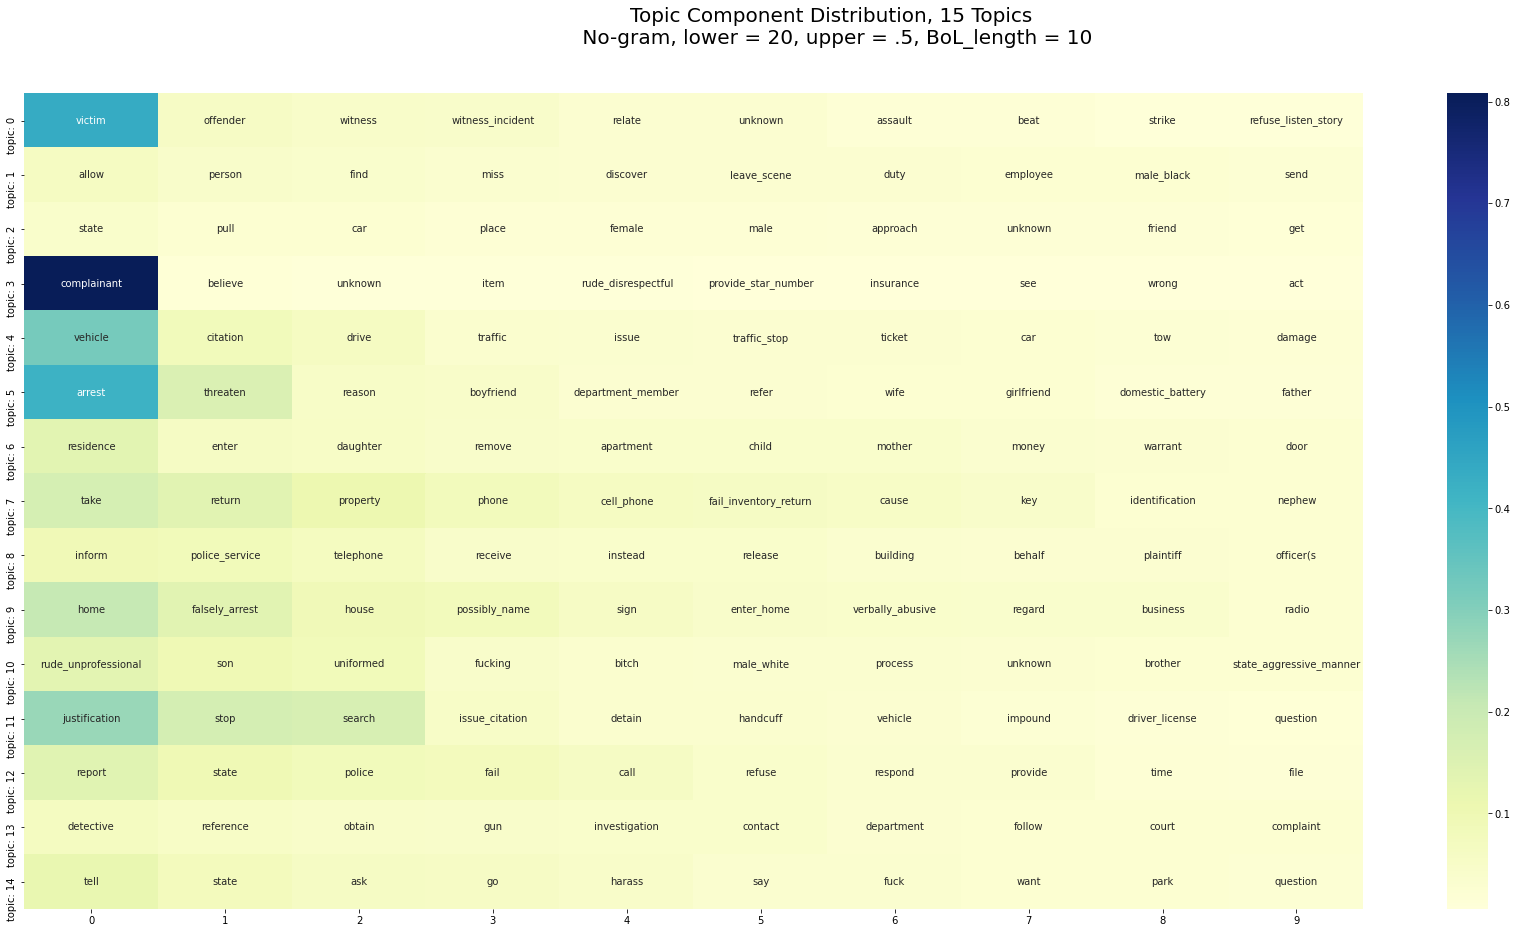

In [20]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 15 Topics \n No-gram, lower = 20, upper = .5, BoL_length = 10", size = 20, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_trigram_15topics1.png')

#### pyLDAvis Principal Component Visualization

In [21]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_trigram_15topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], tri_corpus, tri_id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


#### Most Represetative Documents


In [22]:
dom_topic_df_15 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],tri_corpus, trigram_list_lemmatized_texts,df_list)
top_representatives_15 = PMC_module.return_top_representatives(dom_topic_df_15, num_reps = 10)

In [23]:
top_representatives_15[top_representatives_15['Dominant_Topic'] == 1].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
10,3254,1.0,0.3977,"[allow, person, find, miss, discover, leave_sc...","[cpd, employee, involve, member, colon, angel,...",. _ . . .\nCPD Employee\nINVOLVED MEMBER\nCOLO...
11,25658,1.0,0.3953,"[allow, person, find, miss, discover, leave_sc...","[reporting, party, allege, accuse, officer, pl...",The reporting party alleges that the\naccused ...
12,103,1.0,0.3737,"[allow, person, find, miss, discover, leave_sc...","[star, employee, unit_position, police, office...",Star No. 7621\nEmployee No.\nUnit No. 0447411\...
13,263,1.0,0.3508,"[allow, person, find, miss, discover, leave_sc...","[complainant, nnn, state, arrest, metra, polic...",Complainant NNN stated he was\narrested by Met...
14,1794,1.0,0.3476,"[allow, person, find, miss, discover, leave_sc...","[accuse, accuse, accuse, garcia, louis, unknow...","Accused\nAccused\nAccused\nGARCIA, LOUIS\nUNKN..."
15,264,1.0,0.3348,"[allow, person, find, miss, discover, leave_sc...","[complainant, state, arrest, metra, police, ja...",Complainant HEE stated he was\narrested by Met...
16,18840,1.0,0.3344,"[allow, person, find, miss, discover, leave_sc...","[plant_suspect_cannabis, find, offender_wallet...","plant, suspect cannabis, was found in the offe..."
17,898,1.0,0.3342,"[allow, person, find, miss, discover, leave_sc...","[reporting, party, allege, accuse, member, att...",The reporting party alleged that the accused\n...
18,467,1.0,0.3340,"[allow, person, find, miss, discover, leave_sc...","[complainant, allege, officer, swanson, grab, ...",The complainant alleged that Officer\nSwanson ...
19,14739,1.0,0.3243,"[allow, person, find, miss, discover, leave_sc...","[cpd, accuse, unknown, duty, complainant, alle...","CPD Accused UNKNOWN, ON Duty The complainant a..."


In [24]:
topic_of_interest = 1
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_15[top_representatives_15['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 1
---------
. _ . . .
CPD Employee
INVOLVED MEMBER
COLON, ANGEL
RD No §- Event No, - CB No.
OG# fesse?
Attachment #__.~
4/2/2014
 
CPD 0361925
------
The reporting party alleges that the
accused officers planted drugs on him
assuming that he was someone else that
they were chasing
The reporting party alleges that the accused
officers planted drugs on him assuming that
he was someone else that they were
chasing.
------
Star No. 7621
Employee No.
Unit No. 0447411
Position POLICE OFFICER
Status Active
Preferred Language ENGLISH
Relati hip CO-WORKER -
siatonship Cc LOG #/0 70827
Injuries? Yes - ABRASION TO HAND
Attachment #77 _
CPD 0567390
------
Complainant NNN stated he was
arrested by Metra Police on 10 January
2015, and brought to a CPD holding facility
a Nleged that as he prepared to be
released from custody, the accused
elbowed him in the neck, slammed his head
against a wall_and pressed his elbow
against EEE chest
------
Accused
Accused
Accused
GARCIA, LOUIS
UNKNOWN,
UNKNOWN,